# Chapter3 MCMCの中をのぞいてみよう

## 例題1:混合モデルの教師なしクラスタリング

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

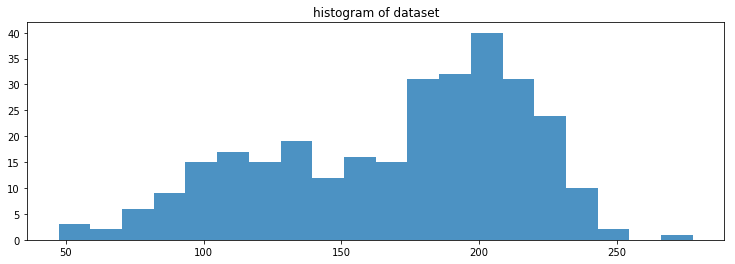

In [2]:
figsize(12.5, 4)

data = np.loadtxt("data/mixture_data.csv", delimiter=',')
plt.hist(data, bins=20, alpha=0.8)
plt.title("histogram of dataset")

In [13]:
data.shape

(300,)

### モデル
- 2つのクラスタから生成されたデータ（クラスタは正規分布で表現する）
    - 確率pでクラスタoを選択
    - パラーメタ$\mu_i$と$\sigma_i$の正規分布からデータをサンプル
    - これらを繰り返す
- 正規分布のパラメータを$\mu_i$と$\sigma_i$
- クラスタの選択確率$p$は一様分布から始める

In [3]:
import pymc as pm
p = pm.Uniform("p", 0., 1.)
# クラスタの選択を表すstochastic変数の定義
assignment = pm.Categorical("assignment", [p, 1-p], size=data.shape[0])

# 母分布のパラメータの事前分布
## 精度（分散）
taus = 1.0 / pm.Uniform("stds", 0, 33, size=2)**2 # 分散の逆数が精度$\tau$
## 平均。正規分布を事前分布とする。目視でだいたいこのあたりというのを初期値にしている
centers = pm.Normal("centers", [120, 190], [0.01, 0.01], size=2)
## size=2としていて、2つの独立した乱数列を生成している

# 0or1のクラスタを割り当てるためのdeterministic変数の定義
## クラスタiを割り当てるということは、正規分布のパラメータcentersとtausのどっちを使うかということ
@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]
@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

# 観測と結びつける
observations = pm.Normal("obs", center_i, tau_i, value=data, observed=True)

# Modelクラスを作成
model=pm.Model([p, assignment, taus, centers])
# MCMCの探索アルゴリズムを実行するクラス
mcmc = pm.MCMC(model)
mcmc.sample(60000, 10000) # バーンインを導入

 [-----------------100%-----------------] 60000 of 60000 complete in 27.6 sec

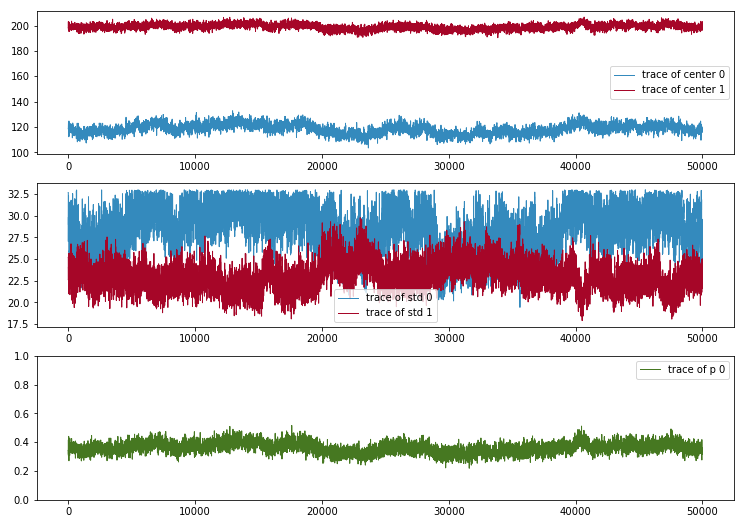

In [4]:
figsize(12.5, 9)
line_width = 1

#色
colors = ["#348abd", "#a60628"]

plt.subplot(311)
center_trace = mcmc.trace("centers")[:]
plt.plot(center_trace[:,0], label="trace of center 0", c=colors[0], lw=line_width)
plt.plot(center_trace[:,1], label="trace of center 1", c=colors[1], lw=line_width)
plt.legend()

plt.subplot(312)
std_trace = mcmc.trace("stds")[:]
plt.plot(std_trace[:,0], label="trace of std 0", c=colors[0], lw=line_width)
plt.plot(std_trace[:,1], label="trace of std 1", c=colors[1], lw=line_width)
plt.legend()

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="trace of p 0", c="#467821", lw=line_width)
plt.ylim(0,1)
plt.legend()


### クラスタを求める

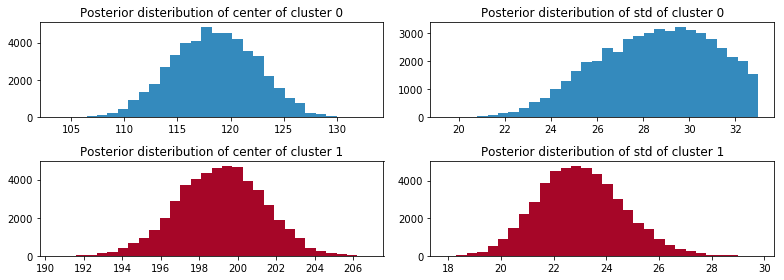

In [5]:
figsize(11.0, 4)
std_trace = mcmc.trace("stds")[:]

_i = [1,2,3,4]
for i in range(2):
    plt.subplot(2,2,_i[2*i])
    # 平均の事後分布
    plt.hist(center_trace[:,i], color=colors[i], bins=30)
    plt.title("Posterior disteribution of center of cluster %d"%i)
    # 分散の事後分布
    plt.subplot(2,2,_i[2*i+1])
    plt.hist(std_trace[:,i], color=colors[i], bins=30)
    plt.title("Posterior disteribution of std of cluster %d"%i)
    
plt.tight_layout()

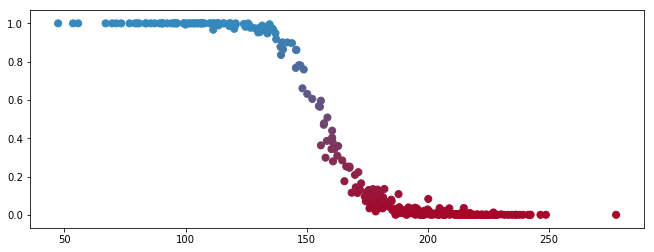

In [6]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)

assign_trace = mcmc.trace("assignment")[:]
plt.scatter(data, 1-assign_trace.mean(axis=0), cmap=cmap, c=assign_trace.mean(axis=0), s=50)


In [7]:
assign_trace.shape

(50000, 300)

In [8]:
center_trace.shape

(50000, 2)

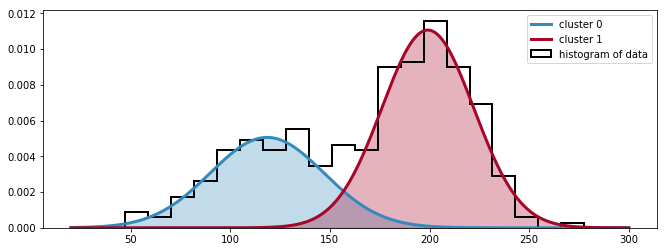

In [9]:
import scipy.stats as stats
norm = stats.norm

x=np.linspace(20, 300, 500)
# 事後分布の平均を推定パラメータとする
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean()

# 元のデータ分布
plt.hist(data, bins=20, normed=True, 
         histtype="step", color="k", lw=2, label="histogram of data")

y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0], scale=posterior_std_means[0])
plt.plot(x, y, lw=3, color=colors[0], label="cluster 0")
plt.fill_between(x, y, color=colors[0], alpha=0.3)

y = (1-posterior_p_mean) * norm.pdf(
    x, loc=posterior_center_means[1], scale=posterior_std_means[1])
plt.plot(x, y, lw=3, color=colors[1], label="cluster 1")
plt.fill_between(x, y, color=colors[1], alpha=0.3)

plt.legend()

### データがどちらのクラスタであるかを予測
- x=175を観測した時にどちらのクラスから生成されたものか予測したい
- 平均が近いところというやり方は簡単だが、ばらつきを無視しているので、良いやり方とはいえない
- ベイズ推定する
$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

xを観測して、クラスタ0に属するか1に属するかの確率の大小を計算したい

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 )
\end{align}

\begin{align}
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}

大小だけわかれば良いので、分母を無視できる。

In [10]:
norm_pdf = stats.norm.pdf

p_trace = mcmc.trace("p")[:]
x=175

v = (p_trace * norm_pdf(x, loc=center_trace[:,0], scale=std_trace[:,0]) > 
     (1-p_trace) * norm_pdf(x, loc=center_trace[:,1], scale=std_trace[:,1])
    )
print(v.mean())

0.0


In [12]:
(center_trace[:,0] > center_trace[:,1]).sum()

0